# Compare tensorflow VS librosa mel spectrogram

In [1]:
%load_ext autoreload
%autoreload 2
import os
import json
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

import librosa

from phaunos_ml.utils import tf_utils
from phaunos_ml.utils.feature_utils import AudioSegmentExtractor
import tensorflow as tf

tf.enable_eager_execution()

## Get some audio examples

In [2]:
TFRECORD_PATH = '/home/jul/data/xenocanto/custom_subsets/subset_1570008079/features/'
AUDIO_DIRNAME = 'audio/wav_22050hz_MLR'

In [3]:
# configure audio segment extractor
sr = 22050
segment_dur = 1
segment_hop_dur = 1
audio_ex = AudioSegmentExtractor(sr=sr, example_duration=segment_dur, example_hop_duration=segment_hop_dur)

In [4]:
# get some audio
example_filenames = random.sample(os.listdir(os.path.join(TFRECORD_PATH, 'positive', AUDIO_DIRNAME)), 2)

In [5]:
example_filenames

['XC296256.M.tf', 'XC373120.M.tf']

In [6]:
example1 = tf_utils.tfrecord2example(os.path.join(TFRECORD_PATH, 'positive', AUDIO_DIRNAME, example_filenames[0]), audio_ex)
example2 = tf_utils.tfrecord2example(os.path.join(TFRECORD_PATH, 'positive', AUDIO_DIRNAME, example_filenames[1]), audio_ex)

W1008 15:30:21.113941 140183051257664 deprecation.py:323] From /home/jul/dev/phaunos_ml/phaunos_ml/utils/tf_utils.py:44: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


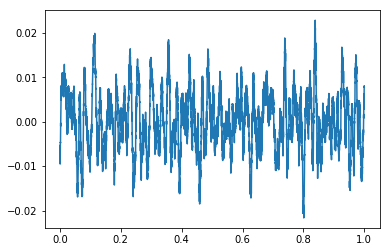

In [7]:
audio_ex.plot(example1[0]['data'][0])

## Compute mel spectrogram

In [8]:
# mel spectrogram parameters
n_fft = 512
hop_length = 128
min_freq = 50
max_freq = 8000
n_mels = 64

In [9]:
# tensorflow spectrogram
tf_spec = tf.abs(tf.contrib.signal.stft(
    example1[0]['data'][0],                                        
    frame_length=n_fft, 
    frame_step=hop_length,
    fft_length=n_fft))
tf_spec

W1008 15:30:21.913968 140183051257664 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



<tf.Tensor: id=363, shape=(169, 257), dtype=float32, numpy=
array([[2.1459846e+00, 1.1942273e+00, 4.3523736e-02, ..., 2.2405772e-03,
        2.0992926e-03, 3.5648346e-03],
       [1.7582223e+00, 1.2015960e+00, 3.4930950e-01, ..., 3.1771343e-03,
        2.8688642e-03, 2.4971962e-03],
       [9.1883957e-01, 3.8488135e-01, 5.0589371e-01, ..., 3.3237890e-03,
        2.3777082e-03, 5.9363246e-04],
       ...,
       [1.3788118e+00, 1.2977539e+00, 1.0130684e+00, ..., 1.6716453e-03,
        1.9192311e-03, 1.9560456e-03],
       [3.0192631e-01, 3.0875528e-01, 5.9547728e-01, ..., 1.7011877e-03,
        4.5844840e-04, 1.4999360e-03],
       [9.4436312e-01, 9.6183813e-01, 7.7167386e-01, ..., 6.7103573e-04,
        1.7417399e-03, 2.1581650e-03]], dtype=float32)>

In [10]:
# librosa spectrogram
lr_spec = np.abs(librosa.core.stft(example1[0]['data'][0].numpy(),                            
                            n_fft=n_fft,
                            hop_length=hop_length,
                            win_length=n_fft,
                            window='hann',
                            center=False,
                            pad_mode='reflect'))
lr_spec.T

array([[2.1459846e+00, 1.1942275e+00, 4.3523759e-02, ..., 2.2405684e-03,
        2.0993298e-03, 3.5648732e-03],
       [1.7582222e+00, 1.2015959e+00, 3.4930950e-01, ..., 3.1771208e-03,
        2.8688351e-03, 2.4972139e-03],
       [9.1883957e-01, 3.8488129e-01, 5.0589377e-01, ..., 3.3238223e-03,
        2.3777345e-03, 5.9366046e-04],
       ...,
       [1.3788117e+00, 1.2977538e+00, 1.0130686e+00, ..., 1.6716406e-03,
        1.9192273e-03, 1.9559935e-03],
       [3.0192626e-01, 3.0875531e-01, 5.9547734e-01, ..., 1.7012035e-03,
        4.5846010e-04, 1.4999479e-03],
       [9.4436318e-01, 9.6183825e-01, 7.7167392e-01, ..., 6.7106198e-04,
        1.7417658e-03, 2.1581894e-03]], dtype=float32)

In [14]:
# tensorflow mel filters
tf_mel_filters = tf.contrib.signal.linear_to_mel_weight_matrix(
    num_mel_bins=n_mels,
    num_spectrogram_bins=tf_spec.shape[-1].value,
    sample_rate=sr,
    lower_edge_hertz=min_freq,
    upper_edge_hertz=max_freq)
tf_mel_filters[90:120,50]

<tf.Tensor: id=642, shape=(30,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.11720774,
       0.34630919, 0.5734516 , 0.79866946, 0.9780141 , 0.7565636 ,
       0.53694576, 0.31912607, 0.10308734, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)>

In [ ]:
# librosa mel filters
lr_mel_filters = librosa.filters.mel(
    sr,
    n_fft,
    n_mels=n_mels,
    fmin=min_freq,
    fmax=max_freq,
    norm=None,
htk=True)
lr_mel_filters.T[90:120,50]

In [ ]:
# tensorflow mel spectrogram
tf_mel_spec = tf.tensordot(tf_spec, tf_mel_filters, 1)
tf_mel_spec

In [ ]:
# librosa mel spectrogram
lr_mel_spec = np.dot(lr_mel_filters, lr_spec)
lr_mel_spec.T